In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import math
import numpy as np

In [3]:
#
# Baseline Bigram Language Model
#

In [6]:
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
!curl -O https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1089k  100 1089k    0     0  3105k      0 --:--:-- --:--:-- --:--:-- 3103k


In [7]:
# Vocab

In [8]:
print("length of dataset in characters: ", len(text), '\n')

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("Unique characters in dataset",''.join(chars))
print("\nTotal number of unique characters in dataset:", vocab_size, '\n')

# let's look at the first 1000 characters
print('----------------------------------------------------------------')
print(text[:1000])

length of dataset in characters:  1115394 

Unique characters in dataset 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

Total number of unique characters in dataset: 65 

----------------------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflic

In [9]:
# Tokenization

In [10]:
# create a mapping from characters to integers (codebook for characters)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

# encoder-decoder functions
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [11]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this


torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [12]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, remaining 10% will be val
train_data = data[:n]
val_data = data[n:]

In [13]:
# Batch

In [14]:
block_size = 8                  # context length
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [15]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [16]:
print('X:', decode(x.tolist()), '  ||  y:', decode(y.tolist()),'\n')
for t in range(block_size):
    context = x[:t+1].tolist()
    target = y[t].tolist()
    print(f"{decode(context)} → {decode([target])}")

X: First Ci   ||  y: irst Cit 

F → i
Fi → r
Fir → s
Firs → t
First →  
First  → C
First C → i
First Ci → t


In [17]:

torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch (batch_size, block_size) of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    # randomly sample a bunch of block_size length sequences
    ix = torch.randint(len(data) - block_size, (batch_size,))  # (batch_size, )
    # the sequence (stack each sequence of the batch indices to form a tensor)
    x = torch.stack([data[i:i+block_size] for i in ix])        # (batch_size, block_size)
    # the target (next character)
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])    # (batch_size, block_size)
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size):            # batch dimension: number of sequences in the batch (batch_size)
    for t in range(block_size):        # time dimension: number of tokens in the sequence  (block_size)
        context = xb[b, :t+1]          # context: taking the first t+1 tokens from the b-th sequence in the input batch
        target = yb[b,t]               # target to predict: take the t-th token from the b-th sequence in the target batch
        print(f"when input is {context.tolist()} the target: {target}")
        

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [23]:
print(decode(xb[0].tolist()))

Let's he


In [24]:
# Bigram LM

In [25]:
-np.log(1/vocab_size)  # vocab_size = 65

4.174387269895637

In [ ]:
#
# only ONE layer cross entropy -- no neural network
#

In [26]:
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C) = (batch_size, time=block_size, channels=vocab_size)

        if targets is None:      # don't compute loss if targets not given (used for generation)
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)             # (B x T, C)
            targets = targets.view(B*T)              # (B x T)
            loss = F.cross_entropy(logits, targets)  # F.cross_entropy inputs shape (B, C, T)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1) ... (B, T+max_new_tokens)
        return idx

bigramLM = BigramLanguageModel(vocab_size)
logits, loss = bigramLM(xb, yb)
print(logits.shape)
print(loss)


torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


In [27]:
# initial context is just a 0 (new line character) with shape 1x1 (1 character, 1 batch)
idx = torch.zeros((1, 1), dtype=torch.long)

# generate 100 new tokens
res = bigramLM.generate(idx, max_new_tokens=100)

# since generate returns a batch of sequences, we just take the first one
res0 = res[0]

# decode the sequence of indices into characters
print(decode(res0.tolist()))
# print(decode(bigramLM.generate(
#     torch.zeros((1, 1), dtype=torch.long), 
#     max_new_tokens=100)[0].tolist()))


SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


In [28]:
#
# Training Bigram LM
#

In [30]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(bigramLM.parameters(), lr=1e-3)  # typical bigger sized NNs: Lr=3e-4

batch_size = 32
for steps in range(10000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = bigramLM(xb, yb)              # forward pass
    optimizer.zero_grad(set_to_none=True)        # clear accumulated gradients
    loss.backward()                              # backward pass (backprop: to get gradients)
    optimizer.step()                             # update parameters

print(loss.item())
print('\n')
print(decode(bigramLM.generate(
    idx = torch.zeros((1, 1), dtype=torch.long),
    max_new_tokens=500)[0].tolist()))

2.382369041442871



lso br. ave aviasurf my, yxMPZI ivee iuedrd whar ksth y h bora s be hese, woweee; the! KI 'de, ulseecherd d o blllando;LUCEO, oraingofof win!
RIfans picspeserer hee tha,
TOFonk? me ain ckntoty ded. bo'llll st ta d:
ELIS me hurf lal y, ma dus pe athouo
BEY:! Indy; by s afreanoo adicererupa anse tecorro llaus a!
OLeneerithesinthengove fal amas trr
TI ar I t, mes, n IUSt my w, fredeeyove
THek' merer, dd
We ntem lud engitheso; cer ize helorowaginte the?
Thak orblyoruldvicee chot, p,
Bealivolde Th li


In [33]:
eval_iters = 200
max_iters = 10000
eval_interval = 500


@torch.no_grad()                           # Disable gradient calculation for this function
def estimate_loss(model):
    out = {}
    model.eval()                           # Set model to evaluation/inference mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()                         # Set model back to training mode
    return out

train_losses = []
val_losses = []
epochs = []

# Training
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss(bigramLM)
        train_losses.append(losses['train'].item())
        val_losses.append(losses['val'].item())
        epochs.append(iter)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = bigramLM(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long)
print(decode(bigramLM.generate(context, max_new_tokens=500)[0].tolist()))

step 0: train loss 2.4485, val loss 2.4889
step 500: train loss 2.4602, val loss 2.4781
step 1000: train loss 2.4645, val loss 2.4826
step 1500: train loss 2.4552, val loss 2.4813
step 2000: train loss 2.4482, val loss 2.4835
step 2500: train loss 2.4597, val loss 2.4901
step 3000: train loss 2.4597, val loss 2.4756
step 3500: train loss 2.4462, val loss 2.4870
step 4000: train loss 2.4553, val loss 2.4841
step 4500: train loss 2.4490, val loss 2.4779
step 5000: train loss 2.4479, val loss 2.4945
step 5500: train loss 2.4527, val loss 2.4696
step 6000: train loss 2.4573, val loss 2.4811
step 6500: train loss 2.4526, val loss 2.4878
step 7000: train loss 2.4530, val loss 2.4781
step 7500: train loss 2.4509, val loss 2.4918
step 8000: train loss 2.4565, val loss 2.4831
step 8500: train loss 2.4674, val loss 2.4872
step 9000: train loss 2.4644, val loss 2.4823
step 9500: train loss 2.4554, val loss 2.4867

NTot?
Flallavests,
F ucke!


UE mal iendy,
TINIsu we ark hin t, noup poure.

IXEvei

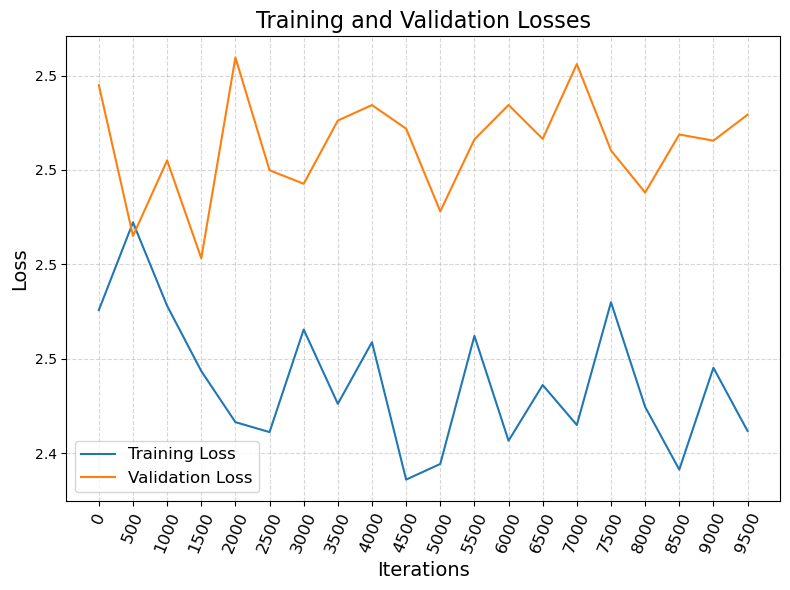

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the training and validation losses
ax.plot(epochs, train_losses, label='Training Loss')
ax.plot(epochs, val_losses, label='Validation Loss')

# Set the x-axis and y-axis labels
ax.set_xlabel('Iterations', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)

# Set the x-axis ticks and labels
ax.set_xticks(epochs)
ax.set_xticklabels(epochs, rotation=67.5, fontsize=12)

# Set the y-axis tick format
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

# Set the title
ax.set_title('Training and Validation Losses', fontsize=16)

# Add a legend
ax.legend(fontsize=12)

# Add grid lines
ax.grid(linestyle='--', alpha=0.5)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [34]:
#
# self attention
#

In [ ]:
#
# V1: Averaging Past Context with For Loops - Weakest Form of Aggregation
#

In [41]:
# consider the following toy example:
# bow -- bag of words

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time (tokens or block_size), channels (vocab_size)
x = torch.randn(B,T,C)
print("x:", x.shape, "\n")

# We want x[b, t] = mean_{i <= t} x[b, i]
xbow = torch.zeros((B, T, C))               # Create tensor of zeros of shape (B, T, C) (bag of words representation of the input)
for b in range(B):                          # For all batches
    for t in range(T):                      # For all tokens in the batch
        xprev = x[b, :t+1]                  # Get all tokens up to and including the current token (t, C)
        xbow[b, t] = torch.mean(xprev, 0)   # Calculate the mean of the tokens up to and including the current token

print('Batch [0]:\n', x[0], "\n")     # First batch of 8 tokens, each of size 2
print('Running Averages (of previous tokens in seq):\n', xbow[0]) # Running averages of the first batch of 8 tokens, each of size 2



x: torch.Size([4, 8, 2]) 

Batch [0]:
 tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]]) 

Running Averages (of previous tokens in seq):
 tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


In [ ]:
#
# V2: Matrix Multiplication
#

In [50]:

# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))            # Lower triangular matrix of ones
a = a / a.sum(dim=1, keepdim=True)          # Normalize the matrix by dividing along each row
b = torch.randint(0, 10, (3, 2)).float()    # 3x2 matrix of random integers between 0 and 9
c = a @ b                                   # Matrix multiplication of a and b

print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c) 

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [53]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
wei
# run matrix multiplication in parallel for all B batch elements, each element has (T,T) X (T,C) --> (T,C)
xbow2 = wei @ x # (T, T) @ (B, T, C) ---auto-stride: broadcast--> (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2, atol=1e-7)


True

In [54]:
xbow2.shape

torch.Size([4, 8, 2])

In [55]:
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [ ]:
#
# V3: Use # version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shapeSoftmax
#

In [57]:
tril = torch.tril(torch.ones(T, T))
tril


tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [58]:
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei


tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [66]:
wei = torch.zeros((T,T))                              # Lower triangular matrix of ones
wei = wei.masked_fill(tril == 0, float('-inf'))       # Replace all the elements of wei where tril == 0 with -inf
wei = F.softmax(wei, dim=-1)                          # Apply softmax to the wei tensor along the last dimension (rows) (dim=-1)
wei


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [67]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
# wei
xbow3 = wei @ x
torch.allclose(xbow, xbow3, atol=1e-7)


True

In [ ]:
#
# Robust Token Embedding Dimension
#

In [102]:
# # hyperparameters
# batch_size = 64           # how many independent sequences will we process in parallel?
# block_size = 256          # what is the maximum context length for predictions?
# max_iters = 5000      
# eval_interval = 500   
# learning_rate = 3e-4 #1e-3  #1e-2
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# eval_iters = 200
# n_embd = 384              # (n_head * batch_size)
# n_head = 6                # (n_embd/batch_size)
# n_layer = 6 
# dropout = 0.2 

In [104]:
import torch.nn as nn

class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd) #new positional embedding table
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device)) #(T, C)
        print("tok_emb: ", tok_emb.shape)
        print("pos_emb: ", tok_emb.shape)
        x = tok_emb + pos_emb # add the positional tokens
        logits = self.lm_head(x) 
        
        if targets is None:      # don't compute loss if targets not given (used for generation)
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)             # (B x T, C)
            targets = targets.view(B*T)              # (B x T)
            loss = F.cross_entropy(logits, targets)  # F.cross_entropy inputs shape (B, C, T)

        return logits, loss


In [79]:
bigramLM = BigramLanguageModel()
logits, loss = bigramLM(xb, yb)
print(logits.shape)
print(loss)

tok_emb:  torch.Size([32, 8, 384])
pos_emb:  torch.Size([32, 8, 384])
torch.Size([256, 65])
tensor(4.4606, grad_fn=<NllLossBackward0>)


In [ ]:
#
# V4: SELF-ATTENTION
#

In [80]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [89]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

In [90]:

k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1)

print("Unscaled Dot-Product Self-Attention")
print(k.var().item().__format__('.4f'))              
print(q.var().item().__format__('.4f'))  
print(wei.var().item().__format__('.4f')) # The variance is larger

wei = q @ k.transpose(-2, -1) * (head_size ** -0.5) # This is the scaled attention, avoiding exploding variance which would sharpen the softmax distributions (and thus make the attention more deterministic)

print("\nScaled Dot-Product Self-Attention")
print(k.var().item().__format__('.4f'))   # The variance is like before
print(q.var().item().__format__('.4f'))   # The variance is like before
print(wei.var().item().__format__('.4f')) # The variance is now much smaller

Unscaled Dot-Product Self-Attention
1.0449
1.0700
17.4690

Scaled Dot-Product Self-Attention
1.0449
1.0700
1.0918


In [91]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)


tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [92]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot


tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [ ]:
#
# TRANSFORMER
#

In [ ]:
# Single Self-Attention

In [93]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)                                               # (B,T,hs)
        q = self.query(x)                                             # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5              # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)                                  # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x)                                             # (B,T,hs)
        out = wei @ v                                                 # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [ ]:
#
# Multi-Head Attention
#

In [94]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


In [ ]:
#
# FFN
#

In [95]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
            nn.Linear(n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [96]:
#
# Residual Connections
#

In [97]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


In [ ]:
#
# LayerNorm
#

In [ ]:
# layerNorm does normalization within features for a given seq
# batchNorm normalizes across one dimension of all the batches (columns)

In [98]:
# Makemore 3's BatchNorm1d
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps                        # Epsilon set to PyTorch default, you may change it
        self.momentum = momentum              # Momemtum set to PyTorch default, you may change it
        self.training = True
        # Initialize Parameters (trained with backprop)
        # (bngain -> gamma, bnbias -> beta)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Initialize Buffers 
        # (Trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward-Pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # Batch mean
            xvar = x.var(0, keepdim=True)   # Batch variance
        else:
            xmean = self.running_mean # Using the running mean as basis
            xvar = self.running_var   # Using the running variance as basis

        # Normalize to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta  # Apply batch gain and bias

        # Update the running buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta] # return layer's tensors

torch.manual_seed(1337)
module = BatchNorm1d(100)
x = torch.randn(32, 100)           # Batch size 32, 100 features (batch size 32 of 100-dimensional vectors)
x = module(x)                      # Forward pass
print("\nBatch Normalization down the columns")
print(x[:,0].mean(), x[:,0].std()) # mean and standard deviation of the 1st feature across all batch inputs (columns) 
print("\nBatch Normalization across the rows")
print(x[0,:].mean(), x[0,:].std(),'\n') # mean and standard deviation of a single input (1st one) from the batch (rows)
print(x[:5,0])                     # See how the feature indicates the normalization feature-wise across the batch, not sample-wise across the features
print(x.shape)                     # Output shape should is the same as input shape


Batch Normalization down the columns
tensor(1.4901e-08) tensor(1.0000)

Batch Normalization across the rows
tensor(0.0411) tensor(1.0431) 

tensor([ 0.0468, -0.1209, -0.1358,  0.6035, -0.0515])
torch.Size([32, 100])


In [99]:
class LayerNorm1d: # (used to be BatchNorm1d)

    def __init__(self, dim, eps=1e-5):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        # calculate the forward pass
        xmean = x.mean(1, keepdim=True) # batch mean
        xvar = x.var(1, keepdim=True) # batch variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
print("x:", x.shape)
print("\nLayer Normalization down the columns")
print(x[:,0].mean(), x[:,0].std()) # mean,std of one feature across all batch inputs
print("\nLayer Normalization across the rows")
print(x[0,:].mean(), x[0,:].std()) # mean,std of a single input from the batch, of its features


x: torch.Size([32, 100])

Layer Normalization down the columns
tensor(0.1469) tensor(0.8803)

Layer Normalization across the rows
tensor(2.3842e-09) tensor(1.0000)


In [100]:
# hyperparameters
batch_size = 64           # how many independent sequences will we process in parallel?
block_size = 256          # what is the maximum context length for predictions?
max_iters = 5000      
eval_interval = 500   
learning_rate = 3e-4 #1e-3  #1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384              # (n_head * batch_size)
n_head = 6                # (n_embd/batch_size)
n_layer = 6 
dropout = 0.2 

In [ ]:
#
# Putting it ALL Together
#

In [112]:
# hyperparameters
batch_size = 16 #64 #16       #32 how many independent sequences will we process in parallel?
block_size = 32 #256 #32       #8 what is the maximum context length for predictions?
max_iters = 5000      #3000
eval_interval = 500   #300
learning_rate = 3e-4 #1e-3  #1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384 #64           #32  (n_head * batch_size)
n_head = 6 #4                   (n_embd/batch_size)
n_layer = 6 #4
dropout = 0.2 #0.0
# ------------

torch.manual_seed(1337)

# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
# with open('input.txt', 'r', encoding='utf-8') as f:
#     text = f.read()

In [113]:

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


In [114]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)   # randomly prevent some of the nodes from communication
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [115]:
torch.manual_seed(1337)
model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))


10.702913 M parameters
step 0: train loss 4.3383, val loss 4.3260
step 500: train loss 2.0793, val loss 2.1335
step 1000: train loss 1.8835, val loss 1.9960
step 1500: train loss 1.7707, val loss 1.9224
step 2000: train loss 1.7117, val loss 1.8837
step 2500: train loss 1.6618, val loss 1.8146
step 3000: train loss 1.6260, val loss 1.7930
step 3500: train loss 1.5903, val loss 1.7723
step 4000: train loss 1.5707, val loss 1.7501
step 4500: train loss 1.5496, val loss 1.7320
step 4999: train loss 1.5220, val loss 1.7276

York in to the change was feel.

BUCKINGHAM:
Nor will stay, be grown,
Thy stouch tinguer on my toe Grey.

SICINIUS:
His my voice in acrewer.

KINGto shall:
The mate it ofther his verions,
I have would lro's que feeth efful,
Inding thou the voish!' Warwick one,
That mays. Wherefore I will he end;
The e'er gar me, good to'er aloud
kniber: I said frese discenter'd cut teous-cal eagre dies pity:
The dow of cown.

QUEEN MARGARET:
I pi--

AUTOLYCUS:
I have thou art a pointetu

In [117]:
import re

log = """
step 0: train loss 4.3383, val loss 4.3260
step 500: train loss 2.0793, val loss 2.1335
step 1000: train loss 1.8835, val loss 1.9960
step 1500: train loss 1.7707, val loss 1.9224
step 2000: train loss 1.7117, val loss 1.8837
step 2500: train loss 1.6618, val loss 1.8146
step 3000: train loss 1.6260, val loss 1.7930
step 3500: train loss 1.5903, val loss 1.7723
step 4000: train loss 1.5707, val loss 1.7501
step 4500: train loss 1.5496, val loss 1.7320
step 4999: train loss 1.5220, val loss 1.7276
"""

# Use regex to extract all (step, train_loss, val_loss)
pattern = r"step\s+(\d+):\s+train loss\s+([\d.]+),\s+val loss\s+([\d.]+)"
matches = re.findall(pattern, log)

# Convert to numeric lists
steps = [int(s) for s, _, _ in matches]
train_loss = [float(t) for _, t, _ in matches]
val_loss = [float(v) for _, _, v in matches]

print("steps =", steps)
print("train_loss =", train_loss)
print("val_loss =", val_loss)

steps = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 4999]
train_loss = [4.3383, 2.0793, 1.8835, 1.7707, 1.7117, 1.6618, 1.626, 1.5903, 1.5707, 1.5496, 1.522]
val_loss = [4.326, 2.1335, 1.996, 1.9224, 1.8837, 1.8146, 1.793, 1.7723, 1.7501, 1.732, 1.7276]


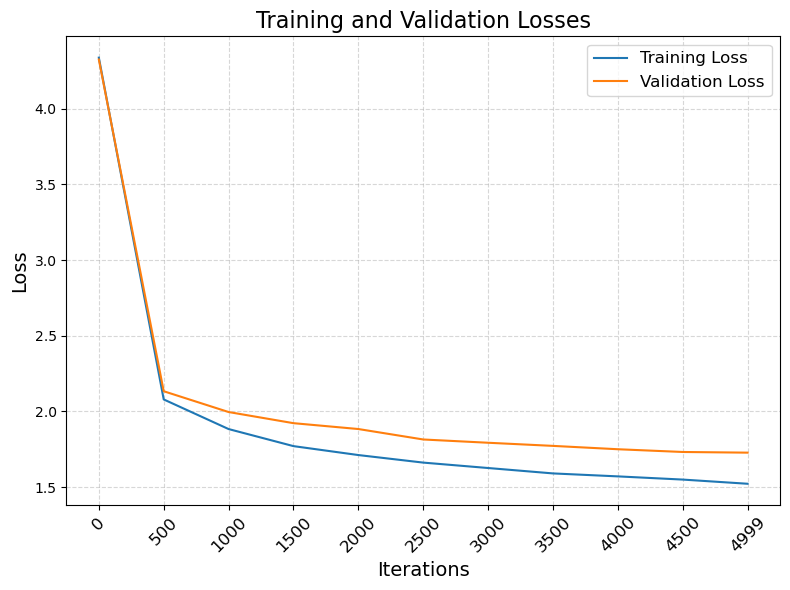

In [118]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the training and validation losses
ax.plot(steps, train_loss, label='Training Loss')
ax.plot(steps, val_loss, label='Validation Loss')

# Set the x-axis and y-axis labels
ax.set_xlabel('Iterations', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)

# Set the x-axis ticks and labels
ax.set_xticks(steps)
ax.set_xticklabels(steps, rotation=45, fontsize=12)

# Set the y-axis tick format
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

# Set the title
ax.set_title('Training and Validation Losses', fontsize=16)

# Add a legend
ax.legend(fontsize=12)

# Add grid lines
ax.grid(linestyle='--', alpha=0.5)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [119]:
# Save and restore the Model Weights

In [120]:
# Save the model weights
torch.save(model.state_dict(), 'model_5000.pth')

# Load the model architecture
model = GPTLanguageModel()
model.load_state_dict(torch.load("model_5000.pth"))
model.eval()

GPTLanguageModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(32, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=384, out_features=64, bias=False)
            (query): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=T

In [123]:
# Save the entire model (including architecture and weights)
torch.save(model, 'model.pth')

# # Load the entire model
# model = torch.load('model.pth')
# model.eval()

model = torch.load("model.pth", weights_only=False)  # PyTorch 2.6+
model.eval()



GPTLanguageModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(32, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=384, out_features=64, bias=False)
            (query): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=T